## Numerical Integration to Calculate Free Energy

In [12]:
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt

import numpy as np
import torch
torch.set_default_dtype(torch.double)
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from sys import exit
import pickle
import scipy.integrate as integrate
import os

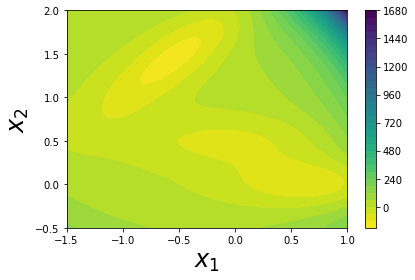

In [13]:
def compute_Muller_potential(beta, x):
    A = (-200., -100., -170., 15.)
    b = (0., 0., 11., 0.6)    
    ac = (x.new_tensor([-1.0, -10.0]),
          x.new_tensor([-1.0, -10.0]),
          x.new_tensor([-6.5, -6.5]),
          x.new_tensor([0.7, 0.7]))
    
    x0 = (x.new_tensor([ 1.0, 0.0]),
          x.new_tensor([ 0.0, 0.5]),
          x.new_tensor([-0.5, 1.5]),
          x.new_tensor([-1.0, 1.0]))
    
    U = 0    
    for i in range(4):
        diff = x - x0[i]
        U = U + A[i]*torch.exp(torch.sum(ac[i]*diff**2, -1) + b[i]*torch.prod(diff, -1))

    return beta*U

def generate_grid(x1_min, x1_max, x2_min, x2_max, ndim1, ndim2):
    x1 = torch.linspace(x1_min, x1_max, steps=ndim1)
    x2 = torch.linspace(x2_min, x2_max, steps=ndim2)
    grid_x1, grid_x2 = torch.meshgrid(x1, x2)
    grid = torch.stack([grid_x1, grid_x2], dim = -1)
    x = grid.reshape((-1, 2))
    return x
    
x1_min, x1_max = -1.5, 1.0
x2_min, x2_max = -0.5, 2.0
ndim = 100

x = generate_grid(x1_min, x1_max, x2_min, x2_max, ndim, ndim)
U = compute_Muller_potential(1, x)
U = U.reshape(ndim, ndim)
U = U.T

fig = plt.figure(0)
fig.clf()
plt.contourf(U, levels = 30, extent = (x1_min, x1_max, x2_min, x2_max), cmap = cm.viridis_r)
#plt.contourf(U, levels = 30, cmap = cm.viridis_r)

plt.xlabel(r"$x_1$", fontsize = 24)
plt.ylabel(r"$x_2$", fontsize = 24)
plt.colorbar()
plt.tight_layout()

In [14]:
def compute_Muller_potential_point(x, y):
    """
    Computes the Muller potential at a point r = (x, y).
    """
    A = (-200., -100., -170., 15.)
    a = (-1, -1, -6.5, 0.7)
    b = (0., 0., 11., 0.6) 
    c = (-10, -10, -6.5, 0.7)
    x0 = (1, 0, -0.5, -1)
    y0 = (0, 0.5, 1.5, 1)

    result = 0
    for k in range(4):
        result += A[k]*np.exp(a[k]*(x-x0[k])**2 + b[k]*(x-x0[k])*(y-y0[k])+ c[k]*(y-y0[k])**2)
    return result 

In [15]:
partition_function = dict()
beta = 0.05
def p_x_y(x, y, beta = 0.05):
    """
    Returns the probability density at a point (x, y).
    """
    U_r = compute_Muller_potential_point(x, y)
    try:
        q = partition_function[beta]
    except:
        q = integrate.nquad(lambda x, y: np.exp(-beta*compute_Muller_potential_point(x , y)), 
        [[-1.5, 1], [-0.5, 2]])
        partition_function[beta] = q
    
    return np.exp(-beta*U_r)/q[0]

basin1_q = integrate.nquad(p_x_y, [[-1.5, 0], [0.55, 2]])
basin2_q = integrate.nquad(p_x_y, [[-0.8, 1], [-0.5, 0.8]])

print(basin1_q)
print(basin2_q)
print(basin1_q[0]/basin2_q[0])

(0.8150038661020849, 1.1571835482893089e-08)
(0.19232117875648097, 1.2028828651238874e-08)
4.237722914198915


In [16]:
print(-np.log(basin1_q[0]/basin2_q[0]))
print(-np.log(basin2_q[0]/basin1_q[0]))
print(-(1/beta)*np.log(basin1_q[0]/basin2_q[0]))

-1.4440260764436557
1.4440260764436557
-28.880521528873114


# Compute Free Energy Difference by Direct Counting From TREMC

In [17]:

d = os.path.abspath('')
with open('x_record_alpha_{:.3f}.pkl'.format(beta), 'rb') as file_handle:
    data = pickle.load(file_handle)
xp = data['x_record'][:, -1, :]


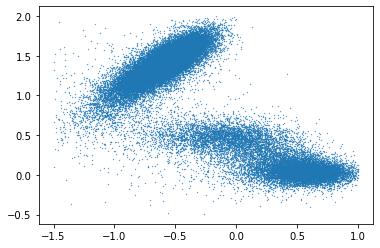

In [18]:
#xp = x_record[:, -1, :]
plt.scatter(xp[:,0], xp[:,1], s = 0.1)


In [19]:
#Sample with TREMC
alpha = 0.05

x1_min, x1_max = -1.5, 1
x2_min, x2_max = -0.5, 2.0

num_reps = 10
alphas = torch.linspace(0.0, alpha, num_reps)

num_steps = 5100000
x_record = []
accept_rate = 0
x = torch.stack((x1_min + torch.rand(num_reps)*(x1_max - x1_min),
                 x2_min + torch.rand(num_reps)*(x2_max - x2_min)),
                dim = -1)
                
energy = compute_Muller_potential(1.0, x)

for k in range(num_steps):
    if (k + 1) % 100000 == 0:
        print("idx of steps: {}".format(k))
        
    ## sampling within each replica
    delta_x = torch.normal(0, 1, size = (num_reps, 2))*0.3
    x_p = x + delta_x
    energy_p = compute_Muller_potential(1.0, x_p)

    ## accept based on energy
    accept_prop = torch.exp(-alphas*(energy_p - energy))
    accept_flag = torch.rand(num_reps) < accept_prop

    ## considering the bounding effects
    accept_flag = accept_flag & torch.all(x_p > x_p.new_tensor([x1_min, x2_min]), -1) \
                              & torch.all(x_p < x_p.new_tensor([x1_max, x2_max]), -1)
    
    x_p[~accept_flag] = x[~accept_flag]
    energy_p[~accept_flag] = energy[~accept_flag]    
    x = x_p
    energy = energy_p

    ## calculate overall accept rate
    accept_rate = accept_rate + (accept_flag.float() - accept_rate)/(k+1)    
    
    ## exchange
    if k % 10 == 0:
        for i in range(1, num_reps):
            accept_prop = torch.exp((alphas[i] - alphas[i-1])*(energy[i] - energy[i-1]))
            accept_flag = torch.rand(1) < accept_prop
            if accept_flag.item():
                tmp = x[i]
                x[i] = x[i-1]
                x[i-1] = tmp

                tmp = energy[i]
                energy[i] = energy[i-1]
                energy[i-1] = tmp
                
        if k >= 10000:
            x_record.append(x.clone().numpy())

x_record = np.array(x_record)


'\nalpha = 0.05\n\nx1_min, x1_max = -1.5, 1\nx2_min, x2_max = -0.5, 2.0\n\nnum_reps = 10\nalphas = torch.linspace(0.0, alpha, num_reps)\n\nnum_steps = 510000\nx_record = []\naccept_rate = 0\nx = torch.stack((x1_min + torch.rand(num_reps)*(x1_max - x1_min),\n                 x2_min + torch.rand(num_reps)*(x2_max - x2_min)),\n                dim = -1)\n                \nenergy = compute_Muller_potential(1.0, x)\n\nfor k in range(num_steps):\n    if (k + 1) % 100000 == 0:\n        print("idx of steps: {}".format(k))\n        \n    ## sampling within each replica\n    delta_x = torch.normal(0, 1, size = (num_reps, 2))*0.3\n    x_p = x + delta_x\n    energy_p = compute_Muller_potential(1.0, x_p)\n\n    ## accept based on energy\n    accept_prop = torch.exp(-alphas*(energy_p - energy))\n    accept_flag = torch.rand(num_reps) < accept_prop\n\n    ## considering the bounding effects\n    accept_flag = accept_flag & torch.all(x_p > x_p.new_tensor([x1_min, x2_min]), -1)                          

In [20]:
basin1_N = 0
basin2_N = 0

for (x1, x2) in xp:
    if (-1.5 < x1 < 0) and (0.55 < x2 < 2):
        basin1_N += 1
    if (-0.8 < x1 < 1) and (-0.5 < x2 < 0.8):
        basin2_N += 1

print(np.log(basin1_N/basin2_N))
print(np.log(basin2_N/basin1_N))
print(-(1/beta)*np.log(basin1_N/basin2_N))

0.8467326012008227
-0.8467326012008227
-16.934652024016454


In [21]:
x1, x2 = xp[:,0], xp[:,1]

def p_x(x):
    p_x = integrate.quad(lambda y: p_x_y(x, y), -0.5, 2)
    return p_x

def p_y(y):
    p_y = integrate.quad(lambda x: p_x_y(x, y), -1.5, 1)
    return p_y

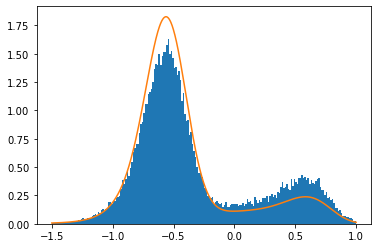

In [22]:
plt.hist(x1, density=True, bins = 200)
lines = np.linspace(-1.5, 1, 1000)
x1_curve = [p_x(l)[0] for l in lines]
plt.plot(lines, x1_curve)
plt.show()

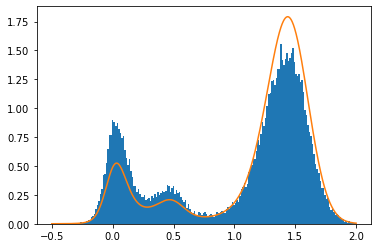

In [23]:
plt.hist(x2, density=True, bins = 200)
lines = np.linspace(-0.5, 2.0, 1000)
x2_curve = [p_y(l)[0] for l in lines]
plt.plot(lines, x2_curve)
plt.show()

## Free Energy Difference By Counting

In [26]:
def compute_Muller_prob(x2, x1, alpha):
    x = torch.tensor([[x1, x2]])
    U = compute_Muller_potential(alpha, x)
    U = U.item()    
    return np.exp(-U)

Z, Z_error = integrate.dblquad(compute_Muller_prob, x1_min, x1_max, x2_min, x2_max, [0.05])

[[-1.5, 0], [0.55, 2]]

F = -np.log(Z)

## Compute Free Energy Difference By Direct Counting From Metropolis-Hastings Monte Carlo

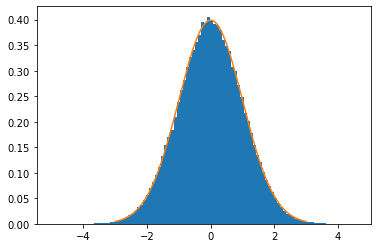

In [24]:
import random 

def normal(x,mu,sigma):
    numerator = np.exp((-(x-mu)**2)/(2*sigma**2))
    denominator = sigma * np.sqrt(2*np.pi)
    return numerator/denominator

def random_coin(p):
    unif = random.uniform(0,1)
    if unif>=p:
        return False
    else:
        return True
    
def gaussian_mcmc(hops,mu,sigma):
    states = []
    burn_in = int(hops*0.2)
    current = random.uniform(-5*sigma+mu,5*sigma+mu)
    for i in range(hops):
        states.append(current)
        movement = random.uniform(-5*sigma+mu,5*sigma+mu)
        
        curr_prob = normal(x=current,mu=mu,sigma=sigma)
        move_prob = normal(x=movement,mu=mu,sigma=sigma)
        
        acceptance = min(move_prob/curr_prob,1)
        if random_coin(acceptance):
            current = movement
    return states[burn_in:]
    
lines = np.linspace(-3,3,1000)
normal_curve = [normal(l,mu=0,sigma=1) for l in lines]
dist = gaussian_mcmc(1000,mu=0,sigma=1)
plt.hist(dist,density=1,bins=100) 
plt.plot(lines,normal_curve)